In [1]:
from collections import Counter, defaultdict
import datetime
import geopandas as gpd
import json
import numpy as np
from math import radians
import matplotlib.pyplot as plt
import pandas as pd
import pgeocode
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import haversine_distances
from uszipcode import SearchEngine
import os

In [217]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 22})

In [3]:
with open('zipcode_to_city_denver.txt', 'r') as f:
    zipcode_to_city_denver = json.loads(f.read())
    
denver_zipcodes = sorted(list(zipcode_to_city_denver))
zipcode_to_city_denver = {zipcode: zipcode_to_city_denver[zipcode] for zipcode in denver_zipcodes}

### Process Neighborhood Scout data

In [4]:
# dataframe mapping ZIP code to census tract (note: a census tract can be in multiple ZIP codes)
zipcode_mapping_df = pd.read_csv('census_tract/zip_tract_crosswalk_2020.csv')
zipcode_mapping_df = zipcode_mapping_df[zipcode_mapping_df['ZIP'].isin(denver_zipcodes)]

In [5]:
zipcode_mapping_df.head()

,ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
141258,80001,8059010305,1.000000,1.000000,1.000000,1.000000
141259,80002,8059010405,0.169287,0.211296,0.249720,0.180082
141260,80002,8059010308,0.273213,0.219934,0.220605,0.263049
141261,80002,8059010406,0.130031,0.324917,0.178052,0.156902
141262,80002,8059010304,0.000000,0.011296,0.008959,0.001998


In [6]:
# census tracts in Denver market area
denver_census_tracts = set(zipcode_mapping_df['TRACT'])

In [7]:
len(denver_census_tracts)

768

In [8]:
# dataframe reporting census tract-level statistics
ct_stats_df = pd.read_csv('census_tract/census_tract_2020_q3.csv')

In [9]:
# census tracts in entire state of Colorado
colorado_census_tracts = set(ct_stats_df[ct_stats_df['state'] == 'CO']['ct_key'])

In [10]:
# limit analysis to census tracts in Denver market area
ct_stats_df = ct_stats_df[ct_stats_df['ct_key'].isin(denver_census_tracts)]
ct_stats_df.drop(columns=['state'], inplace=True)

In [11]:
ct_stats_df.shape

(767, 61)

In [12]:
# dataframe mapping school district to census tract
school_mapping_df = pd.read_csv('census_tract/ct_schooldist_crosswalk_2020.csv')
school_mapping_df = school_mapping_df[['ct_key', 'leaid']]
ct_stats_df = ct_stats_df.merge(school_mapping_df, how='inner', on='ct_key')

In [13]:
ct_stats_df.head()

,ct_key,rent.ct,grrent_yield.ct,rent_br3.ct,rent_br2.ct,rent_br1.ct,rent_br0.ct,cos.ct,lake.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,oth_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,vac_home.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,count_violent.ct,count_property.ct,count_total.ct,pt_violent.ct,pt_property.ct,pt_total.ct,education_score.ct,college_grads.ct,children_poverty.ct,leaid
0,8001007801,1316,6.024884,1625,1403,1143,810,100,100,100,15066.473217,7,10,33,83,93,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,0.0,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,0,0,0.0,0.0,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,100.0,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,53,186,239,14.201501,49.839228,64.040729,11.341791,0.074121,0.420058,802340
1,8001007802,1239,9.187587,2003,1325,1316,1172,100,100,100,15270.696288,7,10,33,83,93,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,0.0,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,0,0,0.0,0.0,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,100.0,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,62,225,287,16.498137,59.872272,76.370410,8.345964,0.029777,0.460476,802340
2,8001007900,1482,10.041348,1984,1504,1192,890,100,100,100,8644.378631,14,6,26,76,86,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,0.0,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,0,0,0.0,0.0,34.526095,65.473905,0.000000,5.882353,82.335231,46.875042,81.712204,100.0,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,66,262,328,11.881188,47.164716,59.045905,9.550928,0.151132,0.279825,802340
3,8001008000,1499,7.532211,1906,1398,1086,,100,100,100,7448.779496,17,3,23,73,83,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.0,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,0,0,0.0,0.0,51.528767,48.471233,0.000000,2.794521,66.152493,27.052337,79.212530,100.0,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,75,265,340,13.061651,46.151167,59.212818,10.130373,0.119054,0.280513,802340
4,8001008100,2203,10.072085,2742,2628,2106,1990,100,100,100,820.952275,71,51,1,19,29,86.148238,12.758202,1.093560,0.000000,3.159174,0.000000,0.000000,90.400972,6.439854,0.0,13.122722,47.995140,30.012151,8.140948,0.729040,0.000000,0,0,0.0,0.0,3.009384,96.990616,0.850547,13.608748,99.648052,40.117025,28.282155,100.0,78.085732,16.726039,99.000522,35.907336,37.837838,11.711712,14.543115,0.000000,9,48,57,10.538642,56.206089,66.744731,12.581497,0.610526,0.169643,802340


In [14]:
ct_stats_df.shape

(872, 62)

In [15]:
# dataframe reporting statistics for each school district
school_df = pd.read_csv('census_tract/school_district_2020.csv')
school_df.head()

,state,leaid,district_name.sd,member.sd,sch.sd,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd
0,AZ,400001,CAVE CREEK UNIFIED DISTRICT (4244),5406,8,23.102564,8,9,81.810155,77.117117
1,AZ,400003,CHINO VALLEY UNIFIED DISTRICT (4474),2348,4,20.271087,6,5,43.544623,50.630631
2,AZ,400004,CLARKDALE-JEROME ELEMENTARY DISTRICT (4486),472,1,20.521739,7,7,65.234942,66.306306
3,AZ,400005,SALOME CONSOLIDATED ELEMENTARY DISTRICT (4514),113,1,14.125,2,1,5.994954,13.603604
4,AZ,400021,COLORADO CITY UNIFIED DISTRICT (4370),673,2,23.614035,7,7,65.689057,66.846847


In [16]:
school_df.drop(columns=['state', 'district_name.sd'], inplace=True, errors='ignore')

In [17]:
ct_stats_df = ct_stats_df.merge(school_df, how='inner', on='leaid')

In [18]:
ct_stats_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [19]:
# convert string columns to float
for column in ct_stats_df.columns:
    if ct_stats_df[column].dtype == 'object':
        ct_stats_df[column] = ct_stats_df[column].astype('float64')

In [20]:
ct_stats_df.shape

(872, 69)

In [21]:
# average statistics for census tracts that encompass multiple school districts
ct_stats_df = ct_stats_df.groupby('ct_key').mean().reset_index()
ct_stats_df.shape

(767, 69)

In [22]:
ct_stats_df.isna().sum()

ct_key                   0
rent.ct                  5
grrent_yield.ct          7
rent_br3.ct             21
rent_br2.ct            122
rent_br1.ct            290
rent_br0.ct            610
cos.ct                   0
lake.ct                  0
frm.ct                   0
pop_density.ct           0
den.ct                   0
urb.ct                   0
sub.ct                   0
rur.ct                   0
rmt.ct                   0
new_pct.ct               0
est_pct.ct               0
old_pct.ct               0
his_pct.ct               0
det_pct.ct               0
att_pct.ct               0
sap_pct.ct               0
lap_pct.ct               0
mob_pct.ct               0
oth_pct.ct               0
bed0_pct.ct              0
bed1_pct.ct              0
bed2_pct.ct              0
bed3_pct.ct              0
bed4_pct.ct              0
bed5_pct.ct              0
base_pct.ct              4
dorms_pct.ct             4
incarc_pct.ct            0
publichou_pct.ct         0
own_pct.ct               0
r

In [23]:
ct_stats_df.head()

,ct_key,rent.ct,grrent_yield.ct,rent_br3.ct,rent_br2.ct,rent_br1.ct,rent_br0.ct,cos.ct,lake.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,oth_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,vac_home.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,count_violent.ct,count_property.ct,count_total.ct,pt_violent.ct,pt_property.ct,pt_total.ct,education_score.ct,college_grads.ct,children_poverty.ct,leaid,member.sd,sch.sd,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd
0,8001007801,1316.0,6.024884,1625.0,1403.0,1143.0,810.0,100.0,100.0,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,0.0,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,0.0,0.0,0.0,0.0,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,100.0,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,53.0,186.0,239.0,14.201501,49.839228,64.040729,11.341791,0.074121,0.420058,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098
1,8001007802,1239.0,9.187587,2003.0,1325.0,1316.0,1172.0,100.0,100.0,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,0.0,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,0.0,0.0,0.0,0.0,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,100.0,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,62.0,225.0,287.0,16.498137,59.872272,76.370410,8.345964,0.029777,0.460476,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098
2,8001007900,1482.0,10.041348,1984.0,1504.0,1192.0,890.0,100.0,100.0,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,0.0,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,0.0,0.0,0.0,0.0,34.526095,65.473905,0.000000,5.882353,82.335231,46.875042,81.712204,100.0,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,66.0,262.0,328.0,11.881188,47.164716,59.045905,9.550928,0.151132,0.279825,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098
3,8001008000,1499.0,7.532211,1906.0,1398.0,1086.0,NaN,100.0,100.0,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.0,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,0.0,0.0,0.0,0.0,51.528767,48.471233,0.000000,2.794521,66.152493,27.052337,79.212530,100.0,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,75.0,265.0,340.0,13.061651,46.151167,59.212818,10.130373,0.119054,0.280513,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098
4,8001008100,2203.0,10.072085,2742.0,2628.0,2106.0,1990.0,100.0,100.0,100.0,820.952275,71.0,51.0,1.0,19.0,29.0,86.148238,12.758202,1.093560,0.000000,3.159174,0.000000,0.000000,90.400972,6.439854,0.0,13.122722,47.995140,30.012151,8.140948,0.729040,0.000000,0.0,0.0,0.0,0.0,3.009384,96.990616,0.850547,13.608748,99.648052,40.117025,28.282155,100.0,78.085732,16.726039,99.000522,35.907336,37.837838,11.711712,14.543115,0.000000,9.0,48.0,57.0,10.538642,56.206089,66.744731,12.581497,0.610526,0.169643,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098


### Population Estimates

In [24]:
def convert_to_ct_key(df):
    df['id'] = [int(ct[-10:]) for ct in df['id']]
    df.rename({'id': 'ct_key'}, inplace=True, axis=1)
    return df

In [25]:
# estimate population of each census tract by calcuating land area and multiplying by population density
# km_per_mi = 1.60934
# colorado_census_tracts_shapes_copy = colorado_census_tracts_shapes.to_crs('epsg:3857')
# colorado_census_tracts_shapes_copy['sq_mi'] = (
#     (colorado_census_tracts_shapes_copy['geometry'].area / 1e6) / (km_per_mi ** 2))
# pop_density_df = ct_stats_df[['ct_key', 'pop_density.ct']]
# different_population_df = pop_density_df.merge(colorado_census_tracts_shapes_copy[['ct_key', 'sq_mi']],
#                                                on='ct_key', how='left')
# different_population_df['population_from_land_area'] = (round(different_population_df['sq_mi'] * 
#                                                         different_population_df['pop_density.ct'])
# different_population_df.drop(columns=['sq_mi', 'pop_density.ct'], inplace=True, errors='ignore')

# plt.figure(figsize=(20, 10))
# plt.hist(different_population_df['population_from_land_area'], bins=50)
# plt.xlabel('population')
# plt.ylabel('number of census tracts')
# plt.title('population of census tract according to density * land area')
# plt.show()

In [26]:
# population of each ZIP code in Colorado (source: https://worldpopulationreview.com/zips/colorado)
colorado_population_df = pd.read_csv('colorado_population.csv')
zipcode_to_population = dict(zip(colorado_population_df['zip'], colorado_population_df['pop']))

In [27]:
# calculate population of each census tract by identifying which ZIP code(s) each census tract falls within
# and multiplying by the RES_RATIO, which represents the ratio of residential addresses in the census tract
# to the total number of residential addresses in the entire ZIP code
census_tract_population_list = []
for ct, df in zipcode_mapping_df.groupby('TRACT'):
    population = 0
    for _, row in df.iterrows():
        zipcode = int(row['ZIP'])
        population += zipcode_to_population.get(zipcode, 0) * row['RES_RATIO']
    census_tract_population_list.append((ct, round(population)))

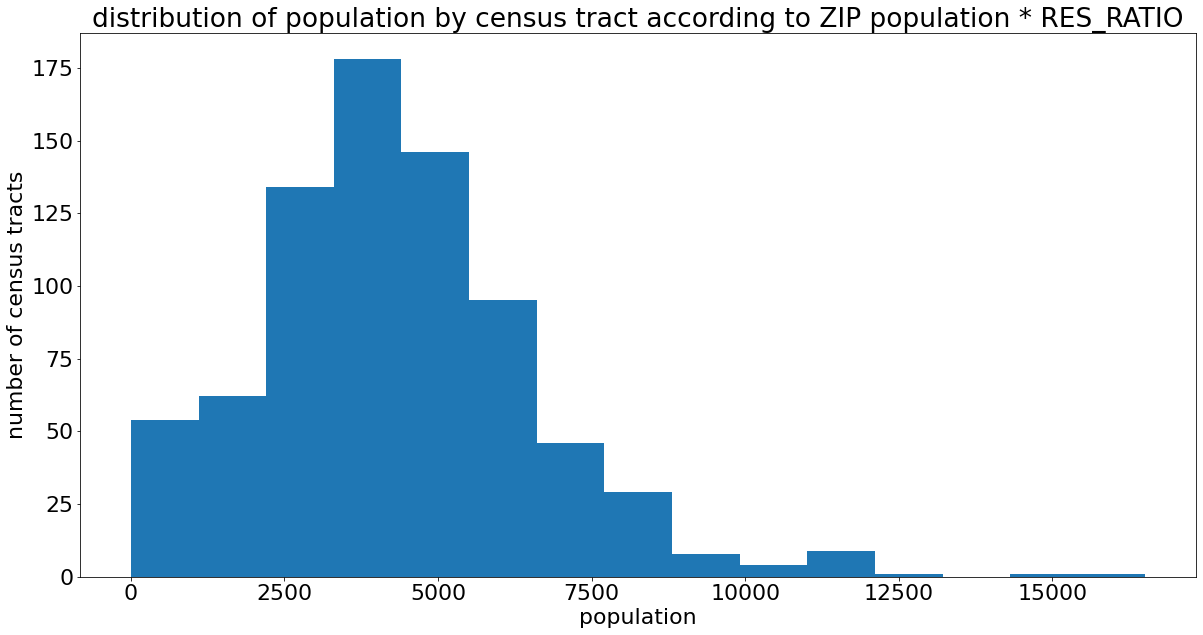

In [28]:
pops = [x[1] for x in census_tract_population_list]
plt.figure(figsize=(20, 10))
plt.hist(pops, bins=15)
plt.xlabel('population')
plt.ylabel('number of census tracts')
plt.title('distribution of population by census tract according to ZIP population * RES_RATIO')
plt.show()

In [29]:
different_population_df = pd.DataFrame(census_tract_population_list, columns=['ct_key', 'res_ratio_population'])

In [30]:
different_population_df.head()

,ct_key,res_ratio_population
0,8001007801,3956
1,8001007802,4480
2,8001007900,5853
3,8001008000,6393
4,8001008100,1294


In [31]:
# AGE AND SEX (2018: ACS 5-Year Estimates Subject Tables)
# https://data.census.gov/cedsci/table?t=Populations%20and%20People&g=0400000US08.140000&tid=ACSST5Y2018.S0101&hidePreview=false
age_demographics_df = pd.read_csv('census_tract/age_demographics.csv', header=1)
age_demographics_df = convert_to_ct_key(age_demographics_df)
age_demographics_df.rename({'Estimate!!Total!!Total population': 'age_census_population'}, axis=1, inplace=True)
age_census_pop_df = age_demographics_df[['ct_key', 'age_census_population']]

In [32]:
different_population_df = different_population_df.merge(age_census_pop_df, on='ct_key', how='left')

In [33]:
different_population_df.head()

,ct_key,res_ratio_population,age_census_population
0,8001007801,3956,4137.0
1,8001007802,4480,4664.0
2,8001007900,5853,5684.0
3,8001008000,6393,6241.0
4,8001008100,1294,1525.0


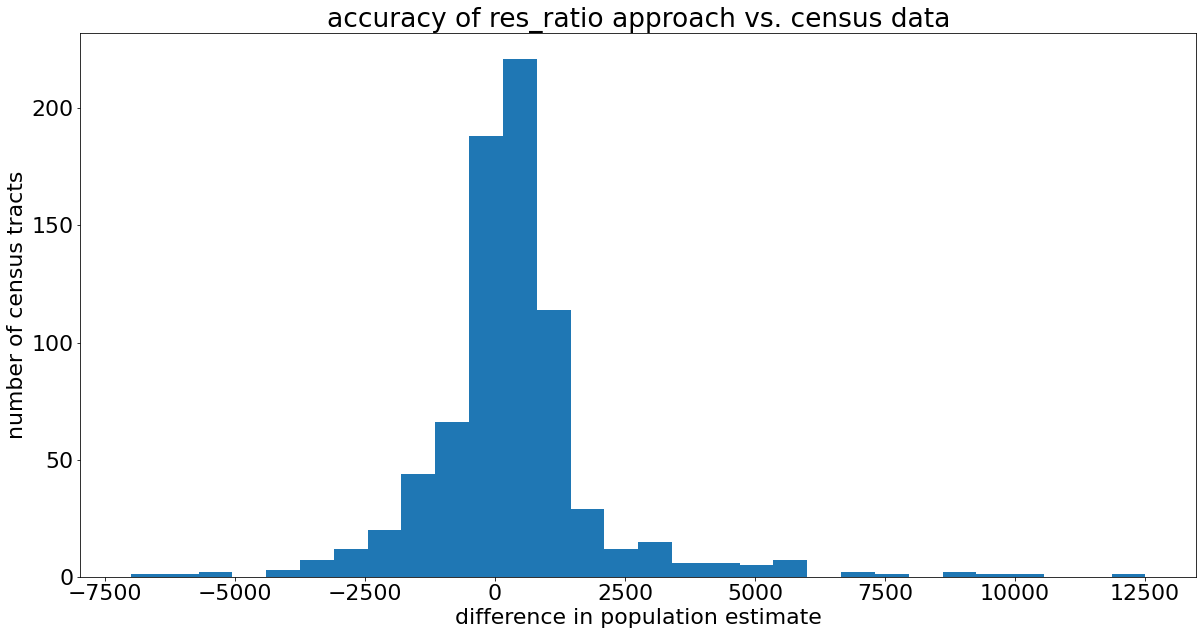

In [34]:
plt.figure(figsize=(20, 10))
plt.hist(different_population_df['age_census_population'] - different_population_df['res_ratio_population'],
         bins=30)
plt.xlabel('difference in population estimate')
plt.ylabel('number of census tracts')
plt.title('accuracy of res_ratio approach vs. census data')
plt.show()

In [35]:
# ACS demographic and housing estimates (2018: ACS 5-Year Estimates Data Profiles)
# (https://data.census.gov/cedsci/table?t=Housing&g=0400000US08.140000&tid=ACSDP5Y2010.DP05&hidePreview=false)
racial_demographics_df = pd.read_csv('census_tract/racial_demographics.csv', header=1)
racial_demographics_df = convert_to_ct_key(racial_demographics_df)
racial_demographics_df.rename({'Estimate!!RACE!!Total population': 'racial_census_population'}, 
                              axis=1, inplace=True)
racial_census_pop_df = racial_demographics_df[['ct_key', 'racial_census_population']]

In [36]:
different_population_df = different_population_df.merge(racial_census_pop_df, on='ct_key', how='left')

In [37]:
for _, row in different_population_df.iterrows():
    age_pop = row['age_census_population']
    race_pop = row['racial_census_population']
    if age_pop != race_pop:
        print(age_pop, race_pop)

nan nan


In [38]:
census_tracts_no_pop_df = different_population_df[(different_population_df['age_census_population'].isna()) |
                                                  (different_population_df['age_census_population'] == 0)]

In [39]:
census_tracts_no_pop_df

,ct_key,res_ratio_population,age_census_population,racial_census_population
96,8001988700,13,0.0,0.0
324,8014060100,0,NaN,NaN
325,8014980100,5,0.0,0.0
470,8031980100,2844,0.0,0.0
676,8059980000,0,0.0,0.0


In [40]:
census_tracts_no_pop = list(census_tracts_no_pop_df['ct_key'])

In [41]:
# ignore census tracts that have 0 population according to the Census Bureau
print(len(ct_stats_df))
ct_stats_df = ct_stats_df[~ct_stats_df['ct_key'].isin(census_tracts_no_pop)]
print(len(ct_stats_df))

767
763


In [42]:
# add population to the census tract level features
ct_stats_df = ct_stats_df.merge(different_population_df[['ct_key', 'age_census_population']], 
                                on='ct_key', how='left')

ct_stats_df.rename({'age_census_population': 'census_population'}, axis=1, inplace=True)
ct_stats_df['census_population'] = ct_stats_df['census_population'].astype(int)

In [43]:
ct_stats_df.head()

,ct_key,rent.ct,grrent_yield.ct,rent_br3.ct,rent_br2.ct,rent_br1.ct,rent_br0.ct,cos.ct,lake.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,oth_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,vac_home.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,count_violent.ct,count_property.ct,count_total.ct,pt_violent.ct,pt_property.ct,pt_total.ct,education_score.ct,college_grads.ct,children_poverty.ct,leaid,member.sd,sch.sd,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd,census_population
0,8001007801,1316.0,6.024884,1625.0,1403.0,1143.0,810.0,100.0,100.0,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,0.0,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,0.0,0.0,0.0,0.0,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,100.0,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,53.0,186.0,239.0,14.201501,49.839228,64.040729,11.341791,0.074121,0.420058,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,4137
1,8001007802,1239.0,9.187587,2003.0,1325.0,1316.0,1172.0,100.0,100.0,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,0.0,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,0.0,0.0,0.0,0.0,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,100.0,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,62.0,225.0,287.0,16.498137,59.872272,76.370410,8.345964,0.029777,0.460476,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,4664
2,8001007900,1482.0,10.041348,1984.0,1504.0,1192.0,890.0,100.0,100.0,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,0.0,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,0.0,0.0,0.0,0.0,34.526095,65.473905,0.000000,5.882353,82.335231,46.875042,81.712204,100.0,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,66.0,262.0,328.0,11.881188,47.164716,59.045905,9.550928,0.151132,0.279825,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,5684
3,8001008000,1499.0,7.532211,1906.0,1398.0,1086.0,NaN,100.0,100.0,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.0,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,0.0,0.0,0.0,0.0,51.528767,48.471233,0.000000,2.794521,66.152493,27.052337,79.212530,100.0,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,75.0,265.0,340.0,13.061651,46.151167,59.212818,10.130373,0.119054,0.280513,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,6241
4,8001008100,2203.0,10.072085,2742.0,2628.0,2106.0,1990.0,100.0,100.0,100.0,820.952275,71.0,51.0,1.0,19.0,29.0,86.148238,12.758202,1.093560,0.000000,3.159174,0.000000,0.000000,90.400972,6.439854,0.0,13.122722,47.995140,30.012151,8.140948,0.729040,0.000000,0.0,0.0,0.0,0.0,3.009384,96.990616,0.850547,13.608748,99.648052,40.117025,28.282155,100.0,78.085732,16.726039,99.000522,35.907336,37.837838,11.711712,14.543115,0.000000,9.0,48.0,57.0,10.538642,56.206089,66.744731,12.581497,0.610526,0.169643,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,1525


## Adding features from Census Bureau

### Age demographics

Age brackets:
1. < 18
2. 18-24
3. 25-34
4. 35-49
5. 50-59
6. 60-64
7. 65-74
8. 75+

In [44]:
age_demographics_df.head(2)

,ct_key,Geographic Area Name,age_census_population,Margin of Error!!Total MOE!!Total population,Estimate!!Percent!!Total population,Margin of Error!!Percent MOE!!Total population,Estimate!!Male!!Total population,Margin of Error!!Male MOE!!Total population,Estimate!!Percent Male!!Total population,Margin of Error!!Percent Male MOE!!Total population,Estimate!!Female!!Total population,Margin of Error!!Female MOE!!Total population,Estimate!!Percent Female!!Total population,Margin of Error!!Percent Female MOE!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Margin of Error!!Total MOE!!Total population!!AGE!!Under 5 years,Estimate!!Percent!!Total population!!AGE!!Under 5 years,Margin of Error!!Percent MOE!!Total population!!AGE!!Under 5 years,Estimate!!Male!!Total population!!AGE!!Under 5 years,Margin of Error!!Male MOE!!Total population!!AGE!!Under 5 years,Estimate!!Percent Male!!Total population!!AGE!!Under 5 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!Under 5 years,Estimate!!Female!!Total population!!AGE!!Under 5 years,Margin of Error!!Female MOE!!Total population!!AGE!!Under 5 years,Estimate!!Percent Female!!Total population!!AGE!!Under 5 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 9 years,Margin of Error!!Total MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Percent!!Total population!!AGE!!5 to 9 years,Margin of Error!!Percent MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Male!!Total population!!AGE!!5 to 9 years,Margin of Error!!Male MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Percent Male!!Total population!!AGE!!5 to 9 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Female!!Total population!!AGE!!5 to 9 years,Margin of Error!!Female MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Percent Female!!Total population!!AGE!!5 to 9 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Total!!Total population!!AGE!!10 to 14 years,Margin of Error!!Total MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Percent!!Total population!!AGE!!10 to 14 years,Margin of Error!!Percent MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Male!!Total population!!AGE!!10 to 14 years,Margin of Error!!Male MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Percent Male!!Total population!!AGE!!10 to 14 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Female!!Total population!!AGE!!10 to 14 years,Margin of Error!!Female MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Percent Female!!Total population!!AGE!!10 to 14 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Total!!Total population!!AGE!!15 to 19 years,Margin of Error!!Total MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Percent!!Total population!!AGE!!15 to 19 years,Margin of Error!!Percent MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Male!!Total population!!AGE!!15 to 19 years,Margin of Error!!Male MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Percent Male!!Total population!!AGE!!15 to 19 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Female!!Total population!!AGE!!15 to 19 years,Margin of Error!!Female MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Percent Female!!Total population!!AGE!!15 to 19 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Total!!Total population!!AGE!!20 to 24 years,Margin of Error!!Total MOE!!Total population!!AGE!!20 to 24 years,Estimate!!Percent!!Total population!!AGE!!20 to 24 years,Margin of Error!!Percent MOE!!Total population!!AGE!!20 to 24 years,Estimate!!Male!!Total population!!AGE!!20 to 24 years,Margin of Error!!Male MOE!!Total population!!AGE!!20 to 24 years,Estimate!!Percent Male!!Total population!!AGE!!20 to 24 years,Margin of Error!!Percent Male MOE!

In [45]:
# age_group_to_column_endings = {'<18': ['Under 5', '5 to 9', '10 to 14', '15 to 17'],
#                                '18-24': ['18 and 19', '20', '21', '22 to 24'],
#                                '25-34': ['25 to 29', '30 to 34'],
#                                '35-49': ['35 to 39', '40 to 44', '45 to 49'],
#                                '50-59': ['50 to 54', '55 to 59'],
#                                '60-64': ['60 and 61', '62 to 64'],
#                                '65-74': ['65 and 66', '67 to 69', '70 to 74'],
#                                '75+': ['75 to 79', '80 to 84', '85 years and over']}

In [46]:
age_group_to_column_endings = {'<18': ['Under 18 years'],
                               '18-24': ['18 to 24'],
                               '25-34': ['25 to 29', '30 to 34'],
                               '35-49': ['35 to 39', '40 to 44', '45 to 49'],
                               '50-59': ['50 to 54', '55 to 59'],
                               '60-64': ['60 to 64'],
                               '65-74': ['65 to 69', '70 to 74'],
                               '75+': ['75 to 79', '80 to 84', '85 years and over']}

In [47]:
age_breakdown_df = pd.DataFrame(age_demographics_df['ct_key'])

In [48]:
for age_group, column_endings in age_group_to_column_endings.items():
    cnt_array = np.zeros(len(age_demographics_df))
    for column_ending in column_endings:
        relevant_columns = [column for column in age_demographics_df.columns
                            if (column.startswith('Estimate!!Total') 
                                and column.split('!!')[-1].startswith(column_ending))]
        for relevant_column in relevant_columns:
            cnt_array += age_demographics_df[relevant_column]
    age_breakdown_df[age_group] = cnt_array / age_demographics_df['age_census_population']

In [49]:
age_breakdown_df.head()

,ct_key,<18,18-24,25-34,35-49,50-59,60-64,65-74,75+
0,8001007801,0.335992,0.086778,0.170897,0.238095,0.062122,0.052937,0.032149,0.021030
1,8001007802,0.286878,0.108276,0.164022,0.275515,0.082547,0.033662,0.032161,0.016938
2,8001007900,0.294159,0.107495,0.200915,0.250000,0.075123,0.033603,0.024982,0.013723
3,8001008000,0.331037,0.079474,0.173690,0.200449,0.094696,0.034289,0.065374,0.020990
4,8001008100,0.075410,0.177049,0.398689,0.155410,0.054426,0.021639,0.042623,0.074754


In [50]:
ct_stats_df = ct_stats_df.merge(age_breakdown_df, on='ct_key', how='left')

### Racial demographics

In [51]:
racial_demographics_df.head(2)

,ct_key,Geographic Area Name,Percent Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Percent Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Percent Margin of Error!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),racial_census_population,Margin of Error!!RACE!!Total population,Percent Estimate!!RACE!!Total population,Percent Margin of Error!!RACE!!Total population,Estimate!!RACE!!Total population!!One race,Margin of Error!!RACE!!Total population!!One race,Percent Estimate!!RACE!!Total population!!One race,Percent Margin of Error!!RACE!!Total population!!One race,Estimate!!RACE!!Total population!!Two or more races,Margin of Error!!RACE!!Total population!!Two or more races,Percent Estimate!!RACE!!Total population!!Two or more races,Percent Margin of Error!!RACE!!Total population!!Two or more races,Estimate!!RACE!!Total population!!One race.1,Margin of Error!!RACE!!Total population!!One race.1,Percent Estimate!!RACE!!Total population!!One race.1,Percent Margin of Error!!RACE!!Total population!!One race.1,Estimate!!RACE!!Total population!!One race!!White,Margin of Error!!RACE!!Total population!!One race!!White,Percent Estimate!!RACE!!Total population!!One race!!White,Percent Margin of Error!!RACE!!Total population!!One race!!White,Estimate!!RACE!!Total population!!One race!!Black or African American,Margin of Error!!RACE!!Total population!!One race!!Black or African American,Percent Estimate!!RACE!!Total population!!One race!!Black or African American,Percent Margin of Error!!RACE!!Total population!!One race!!Black or African American,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native,Margin of Error!!RACE!!Total population!!One race!!American Indian and Alaska Native,Percent Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native,Percent Margin of Error!!RACE!!Total population!!One race!!American Indian and Alaska Native,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,Margin of Error!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,Percent Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,Percent Margin of Error!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,Margin of Error!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,Percent Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,Percent Margin of Error!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,Margin of Error!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,Percent Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,Percent Margin of Error!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,Margin of Error!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,Percent Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,Percent Margin of Error!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,Estimate!!RACE!!Total population!

In [52]:
race_to_column_ending = {'Hispanic': 'Hispanic or Latino (of any race)',
                         'White': 'White alone',
                         'Black': 'Black or African American alone',
                         'Asian': 'Asian alone'}

In [53]:
racial_breakdown_df = pd.DataFrame(racial_demographics_df['ct_key'])

In [54]:
for race, column_ending in race_to_column_ending.items():
    relevant_column = [column for column in racial_demographics_df.columns
                       if column.startswith('Estimate') and column.split('!!')[-1] == column_ending][0]
    racial_breakdown_df[race] = (racial_demographics_df[relevant_column] / 
                                 racial_demographics_df['racial_census_population'])

In [55]:
racial_breakdown_df.head()

,ct_key,Hispanic,White,Black,Asian
0,8001007801,0.459753,0.147450,0.117718,0.239304
1,8001007802,0.569897,0.135077,0.182676,0.067753
2,8001007900,0.552076,0.226249,0.143737,0.020936
3,8001008000,0.521231,0.215350,0.143086,0.055119
4,8001008100,0.228197,0.578361,0.030820,0.097705


In [56]:
for race in race_to_column_ending:
    print(f'percentage of population in Colorado that is {race}:', 
          round(100 * np.mean(racial_breakdown_df[race]), 2))

percentage of population in Colorado that is Hispanic: 21.17
percentage of population in Colorado that is White: 69.2
percentage of population in Colorado that is Black: 3.52
percentage of population in Colorado that is Asian: 2.85


These numbers almost perfectly align with the demographic info here: https://en.wikipedia.org/wiki/Colorado#Demographics

In [57]:
ct_stats_df = ct_stats_df.merge(racial_breakdown_df, on='ct_key', how='left')

### Population growth

In [58]:
sorted_filenames = ['ACSST5Y' + str(year) + '.S0101_data_with_overlays_2020-10-18T043740.csv'
                    for year in range(2010, 2019)]

ct_key_to_population_trend = defaultdict(list)

age_demographics_directory = 'census_tract/age_demographics_2010_2018'
for f in sorted_filenames:
    df = pd.read_csv(f'{age_demographics_directory}/{f}', header=1)
    df = convert_to_ct_key(df)
    try:
        population_column = 'Total!!Estimate!!Total population'
        df = df[['ct_key', population_column]]
    except KeyError:
        population_column = 'Estimate!!Total!!Total population'
        df = df[['ct_key', population_column]]
    
    for _, row in df.iterrows():
        ct_key_to_population_trend[row['ct_key']].append(row[population_column])

In [77]:
denver_census_tracts = set(ct_stats_df['ct_key'])

In [89]:
lin_reg = LinearRegression()

# clip zipcodes that grow faster than an average of 10% per year
def calculate_growth_rate(population_trend, max_annual_growth=0.1):
    lin_reg.fit(np.arange(len(population_trend)).reshape(-1, 1), population_trend)
    slope = lin_reg.coef_[0] / population_trend[0]
    avg_yoy_change = np.mean([(population_trend[i + 1] - population_trend[i]) / population_trend[i] 
                               for i in range(len(population_trend) - 1)])
    
    return min(slope, max_annual_growth), min(avg_yoy_change, max_annual_growth)

In [90]:
population_growth_rate_lst = []
for ct_key, population_trend in ct_key_to_population_trend.items():
    if ct_key in denver_census_tracts:
        population_trend_last_5_years = population_trend[-5:]
        slope_9_yr, avg_yoy_change_9_yr = calculate_growth_rate(population_trend)
        slope_5_yr, avg_yoy_change_5_yr = calculate_growth_rate(population_trend_last_5_years)
        population_growth_rate_lst.append((ct_key, slope_9_yr, avg_yoy_change_9_yr, 
                                           slope_5_yr, avg_yoy_change_5_yr))

In [91]:
columns = ['ct_key', 'linear_pop_trend_since_2010', 'avg_annual_pop_change_since_2010',
           'linear_pop_trend_since_2014', 'avg_annual_pop_change_since_2014']
ct_population_growth_df = pd.DataFrame(population_growth_rate_lst, columns=columns)

In [199]:
ct_population_growth_df.head()

,ct_key,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014
0,8013012607,0.038339,0.035680,0.038530,0.034176
1,8013012608,-0.003471,0.000506,-0.006932,-0.009388
2,8013012701,0.013204,0.015091,0.025325,0.022277
3,8013012705,0.025683,0.027038,0.040293,0.039040
4,8013012707,0.007119,0.013743,-0.003175,-0.009469


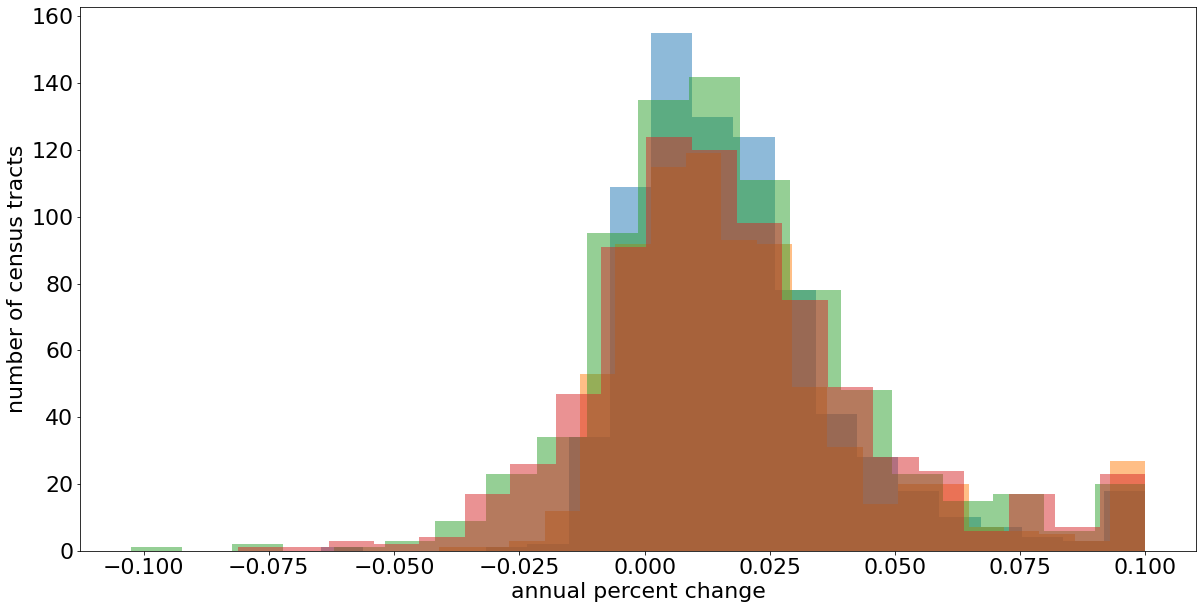

In [98]:
plt.figure(figsize=(20, 10))
plt.hist(ct_population_growth_df['avg_annual_pop_change_since_2010'], bins=20, alpha=0.5)
plt.hist(ct_population_growth_df['linear_pop_trend_since_2010'], bins=20, alpha=0.5)
plt.hist(ct_population_growth_df['avg_annual_pop_change_since_2014'], bins=20, alpha=0.5)
plt.hist(ct_population_growth_df['linear_pop_trend_since_2014'], bins=20, alpha=0.5)
plt.xlabel('annual percent change')
plt.ylabel('number of census tracts')
plt.show()

In [200]:
ct_stats_df = ct_stats_df.merge(ct_population_growth_df, on='ct_key', how='left')

### Fertility

In [185]:
# Fertility 
# https://data.census.gov/cedsci/table?t=Fertility&g=0400000US08.140000&tid=ACSST5Y2018.S1301&hidePreview=false
fertility_df = pd.read_csv('census_tract/fertility.csv', header=1)
fertility_df = convert_to_ct_key(fertility_df)
fertility_df.rename({'Estimate!!Women with births in the past 12 months!!Number!!Women 15 to 50 years': 
                     'number_of_births'}, axis=1, inplace=True)

In [186]:
fertility_df = fertility_df[['ct_key', 'number_of_births']]
fertility_df = fertility_df.merge(ct_stats_df[['ct_key', 'census_population']], on='ct_key', how='right')
fertility_df['annual_births_per_resident'] = fertility_df['number_of_births'] / fertility_df['census_population']

In [187]:
fertility_df.head()

,ct_key,number_of_births,census_population,annual_births_per_resident
0,8001007801,60,4137,0.014503
1,8001007802,59,4664,0.012650
2,8001007900,37,5684,0.006510
3,8001008000,104,6241,0.016664
4,8001008100,15,1525,0.009836


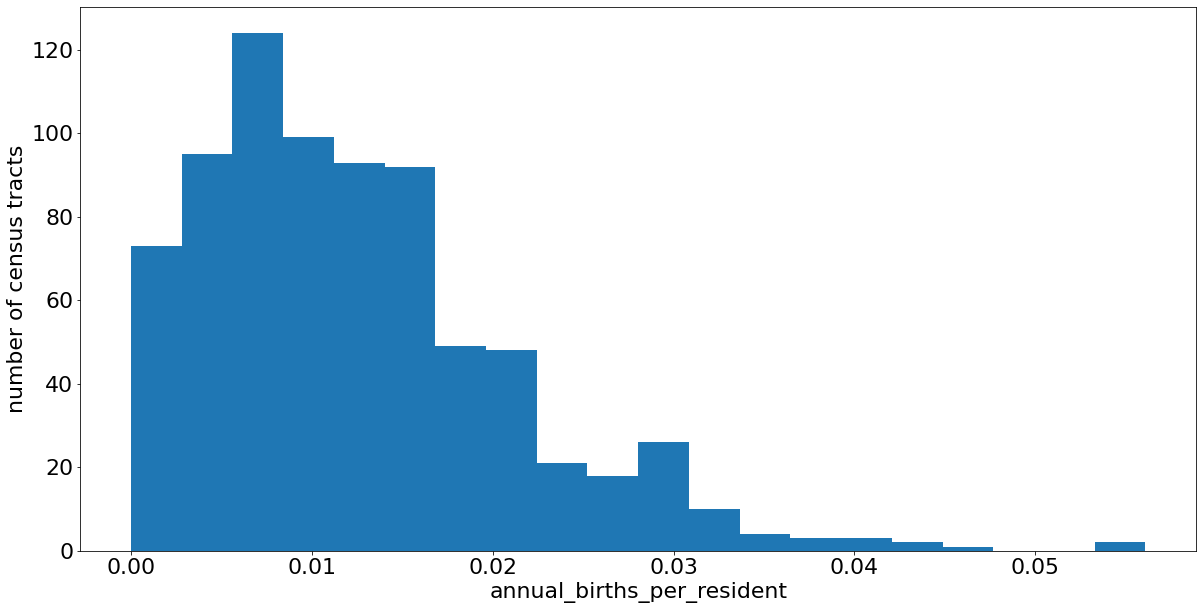

In [188]:
plt.figure(figsize=(20, 10))
plt.hist(fertility_df['annual_births_per_resident'], bins=20)
plt.xlabel('annual_births_per_resident')
plt.ylabel('number of census tracts')
plt.show()

In [189]:
ct_stats_df = ct_stats_df.merge(fertility_df[['ct_key', 'annual_births_per_resident']], on='ct_key', how='left')

### Commuting

In [190]:
# MEANS OF TRANSPORTATION TO WORK BY TENURE
# https://data.census.gov/cedsci/table?t=Housing&g=0400000US08.140000&tid=ACSDT5Y2018.B08137&hidePreview=false
commuting_df = pd.read_csv('census_tract/commuting_mode.csv', header=1)
commuting_df = convert_to_ct_key(commuting_df)
commuting_df.rename({'Estimate!!Total': 'workforce_size'}, axis=1, inplace=True)

In [191]:
commuting_df = commuting_df.merge(ct_stats_df[['ct_key', 'census_population']], on='ct_key', how='right')
commuting_df['workforce_fraction'] = commuting_df['workforce_size'] / commuting_df['census_population']
transit_mode_df = commuting_df[['ct_key', 'workforce_fraction']]

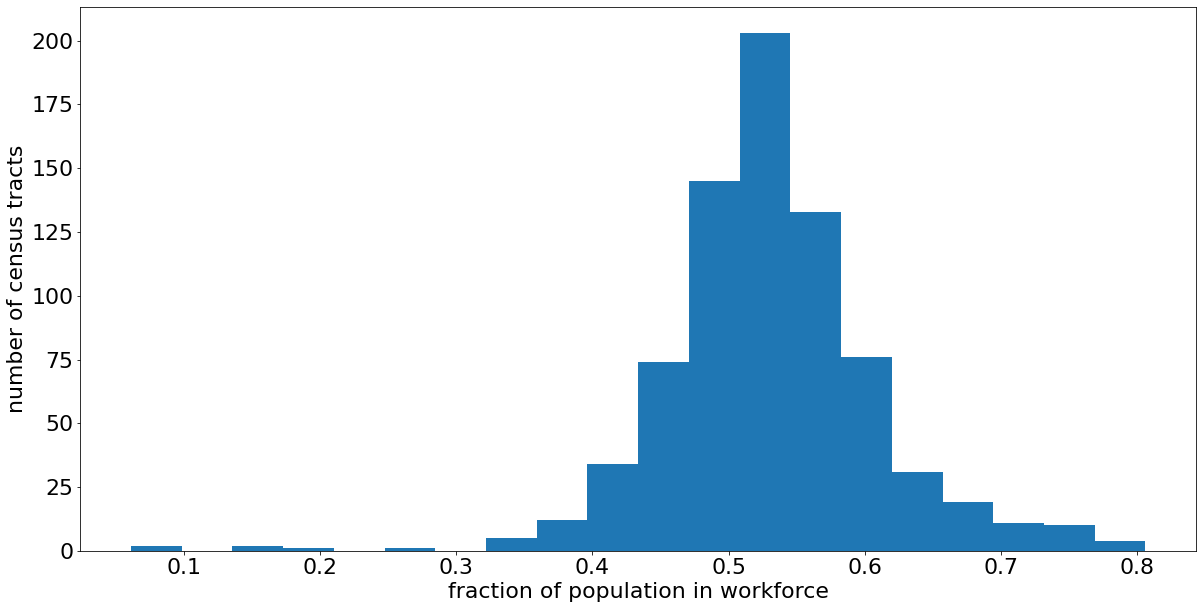

In [192]:
plt.figure(figsize=(20, 10))
plt.hist(transit_mode_df['workforce_fraction'], bins=20)
plt.xlabel('fraction of population in workforce')
plt.ylabel('number of census tracts')
plt.show()

In [193]:
transit_mode_to_column_ending = {'car': 'Car, truck, or van - drove alone', 
                                 'carpool': 'Car, truck, or van - carpooled',
                                 'public_transportation': 'Public transportation',
                                 'walk': 'Walked',
                                 'WFH': 'Worked at home',
                                 'other_mode_of_transit': 'Taxicab, motorcycle, bicycle'}

In [219]:
for transit_mode, column_ending in transit_mode_to_column_ending.items():
    relevant_column = [column for column in commuting_df.columns
                       if (column.startswith('Estimate!!Total') 
                           and column.split('!!')[-1].startswith(column_ending))][0]
    transit_mode_df[transit_mode] = commuting_df[relevant_column] / commuting_df['workforce_size']

In [195]:
transit_mode_df.head()

,ct_key,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit
0,8001007801,0.423012,0.445714,0.258286,0.204571,0.029714,0.020000,0.041714
1,8001007802,0.447256,0.543145,0.233461,0.160594,0.012464,0.009108,0.041227
2,8001007900,0.501407,0.675439,0.168421,0.090175,0.029825,0.016140,0.020000
3,8001008000,0.444160,0.733766,0.152597,0.078283,0.005411,0.021284,0.008658
4,8001008100,0.497049,0.564644,0.122691,0.010554,0.232190,0.043536,0.026385


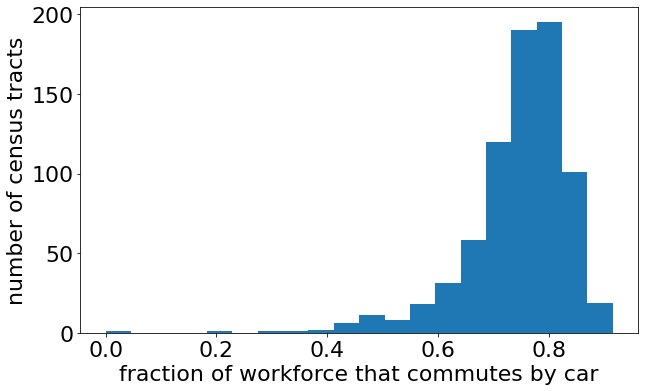

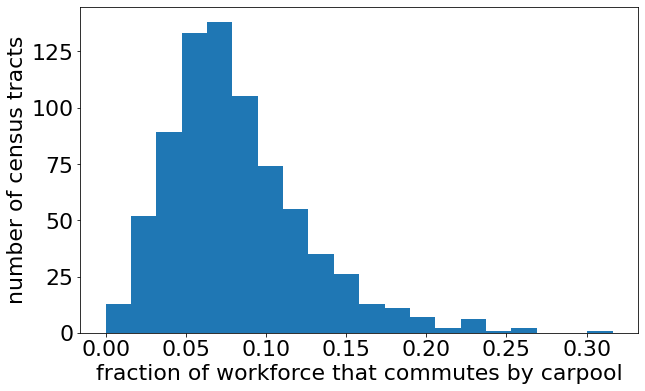

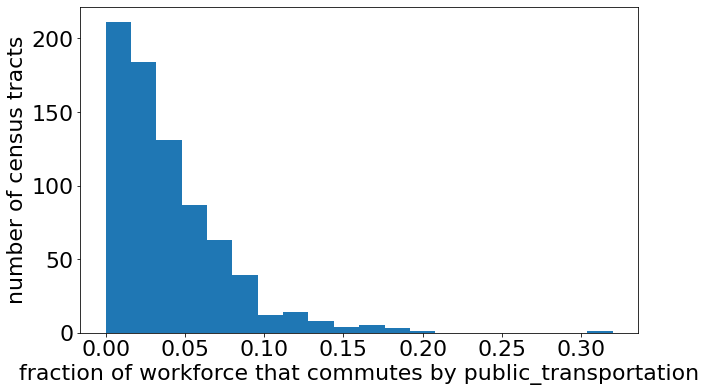

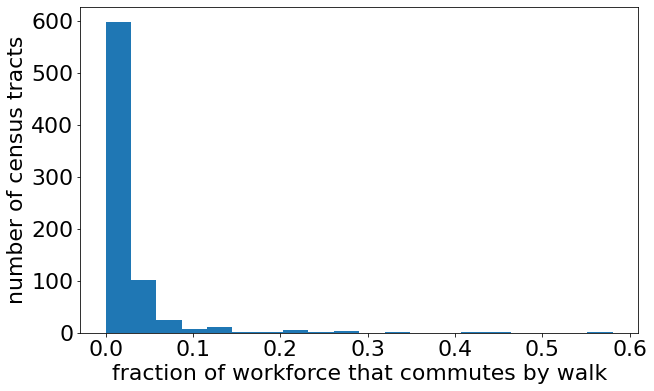

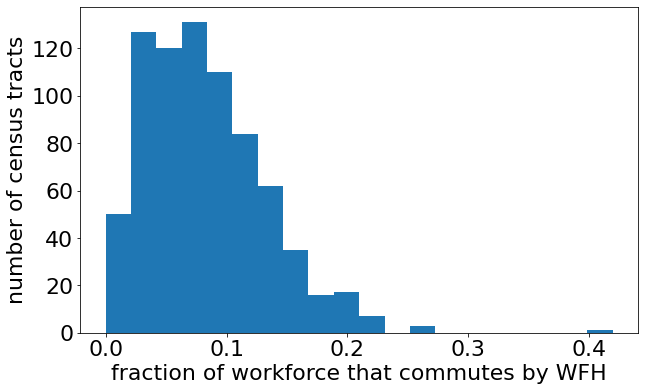

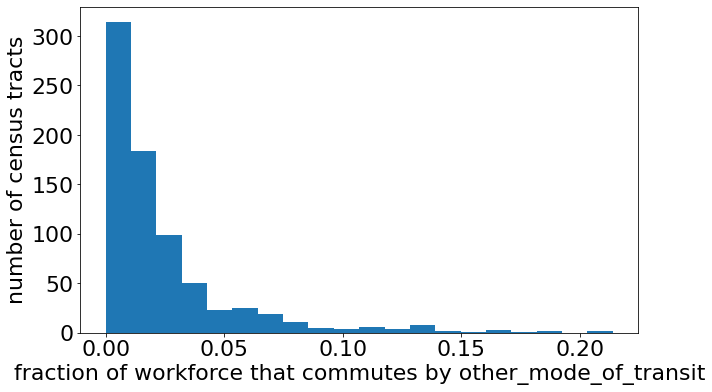

In [196]:
for transit_mode in transit_mode_to_column_ending:
    plt.figure(figsize=(10, 6))
    plt.hist(transit_mode_df[transit_mode], bins=20)
    plt.xlabel(f'fraction of workforce that commutes by {transit_mode}')
    plt.ylabel('number of census tracts')

In [197]:
ct_stats_df = ct_stats_df.merge(transit_mode_df, on='ct_key', how='left')

### Income

In [437]:
# INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)
# https://data.census.gov/cedsci/table?t=Income%20%28Households,%20Families,%20Individuals%29&g=0400000US08.140000&tid=ACSST5Y2018.S1901&hidePreview=false
income_df = pd.read_csv('census_tract/income.csv', header=1)
income_df = convert_to_ct_key(income_df)
income_df = income_df[income_df['ct_key'].isin(denver_census_tracts)]

According to https://www.census.gov/programs-surveys/cps/technical-documentation/subject-definitions.html

A household consists of all the people who occupy a housing unit. A house, an apartment or other group of rooms, or a single room, is regarded as a housing unit when it is occupied or intended for occupancy as separate living quarters; that is, when the occupants do not live with any other persons in the structure and there is direct access from the outside or through a common hall. 

A household includes the related family members and all the unrelated people, if any, such as lodgers, foster children, wards, or employees who share the housing unit. A person living alone in a housing unit, or a group of unrelated people sharing a housing unit such as partners or roomers, is also counted as a household. The count of households excludes group quarters. There are two major categories of households, "family" and "nonfamily". 

A family is a group of two people or more (one of whom is the householder) related by birth, marriage, or adoption and residing together; all such people (including related subfamily members) are considered as members of one family.

A nonfamily household consists of a householder living alone (a one-person household) or where the householder shares the home exclusively with people to whom he/she is not related.

In [438]:
column_to_new_column = {'Estimate!!Households!!Total': 'total_households',
                        'Estimate!!Families!!Total': 'total_families_households',
                        'Estimate!!Nonfamily households!!Total': 'total_nonfamily_households',
                        'Estimate!!Households!!Median income (dollars)': 'median_household_income',
                        'Estimate!!Families!!Median income (dollars)': 'median_family_income',
                        'Estimate!!Nonfamily households!!Median income (dollars)': 'median_nonfamily_income',
                        'Estimate!!Households!!Mean income (dollars)': 'mean_household_income',
                        'Estimate!!Families!!Mean income (dollars)': 'mean_family_income',
                        'Estimate!!Nonfamily households!!Mean income (dollars)': 'mean_nonfamily_income'}

In [439]:
income_df = income_df[['ct_key'] + list(column_to_new_column)]
income_df.rename(column_to_new_column, axis=1, inplace=True)

In [440]:
income_df['family_households_fraction'] = income_df['total_families_households'] / income_df['total_households']
income_df['nonfamily_households_fraction'] = (income_df['total_nonfamily_households'] / 
                                              income_df['total_households'])

income_df.drop(['total_households', 'total_families_households', 'total_nonfamily_households'], axis=1,
               inplace=True)

In [441]:
income_df.head(2)

,ct_key,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction
0,8001007801,32744,40921,19534,42004,49152,30554,0.595313,0.404687
1,8001007802,30598,31685,26144,41771,41349,39394,0.660900,0.339100


In [442]:
income_df[(income_df['median_family_income'] == '-') |
          (income_df['mean_nonfamily_income'] == 'N')]

,ct_key,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction
261,8013012202,38194,-,38491,56976,67830,54912,0.159760,0.840240
395,8031001902,125625,-,-,153220,159683,147932,0.450000,0.550000
403,8031002701,41957,-,40933,53589,97217,48127,0.111266,0.888734
983,8069002803,47500,-,47500,49611,-,49611,0.000000,1.000000
1228,8123002017,145938,145938,-,175672,175994,N,0.963134,0.036866


In [443]:
income_df.replace(to_replace='250,000+', value='250000', inplace=True)

In [444]:
for summary_stat in ['median', 'mean']:
    for family_type in ['family', 'nonfamily']:
        income_df[f'{summary_stat}_{family_type}_income'] = (
            income_df.apply(lambda x: x[f'{summary_stat}_household_income']
            if x[f'{summary_stat}_{family_type}_income'] in {'-', 'N'} 
            else x[f'{summary_stat}_{family_type}_income'], axis=1))

In [445]:
for column in income_df.columns:
    if column.split('_')[0] in {'median', 'mean'}:
        income_df[column] = income_df[column].astype(int)

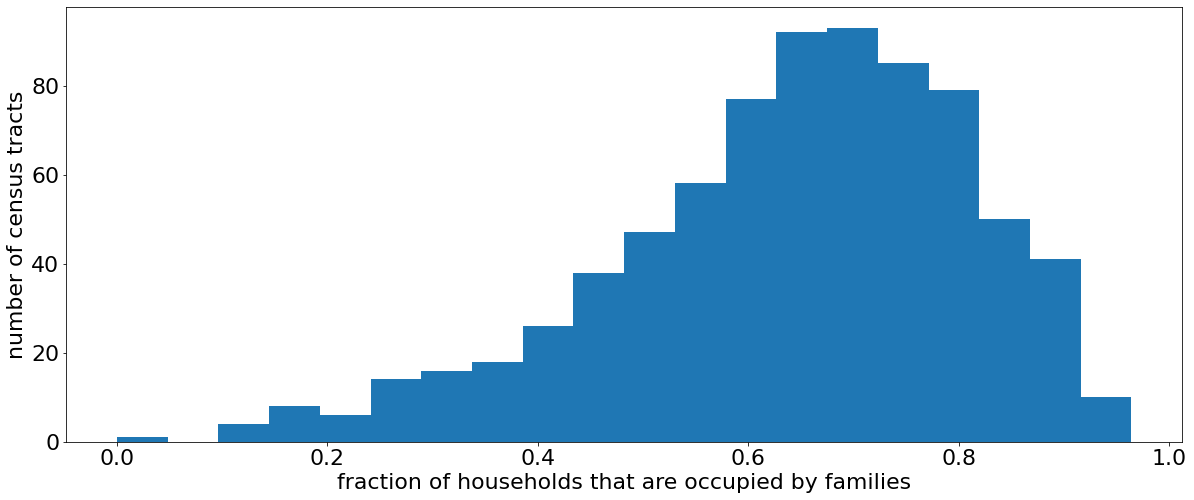

In [455]:
plt.figure(figsize=(20, 8))
plt.hist(income_df['family_households_fraction'], bins=20)
plt.xlabel('fraction of households that are occupied by families')
plt.ylabel('number of census tracts')
plt.show()

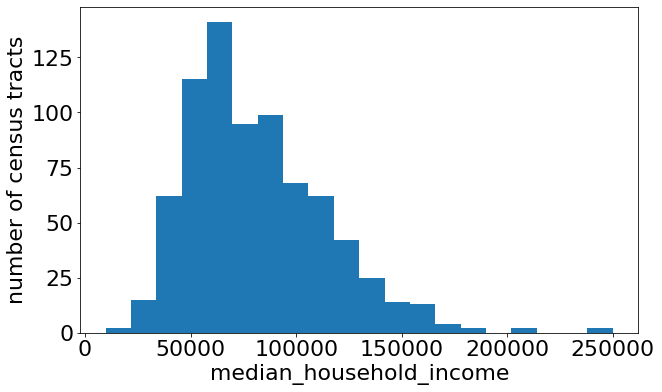

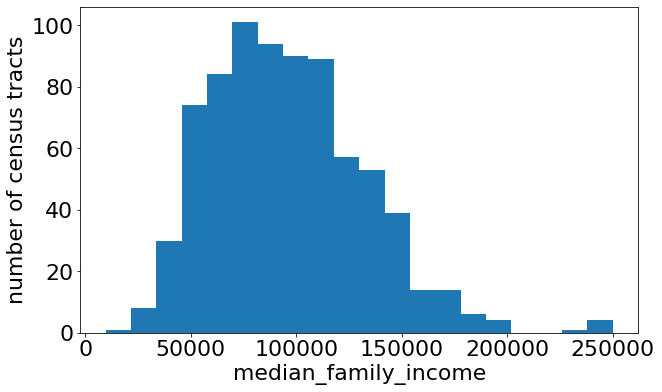

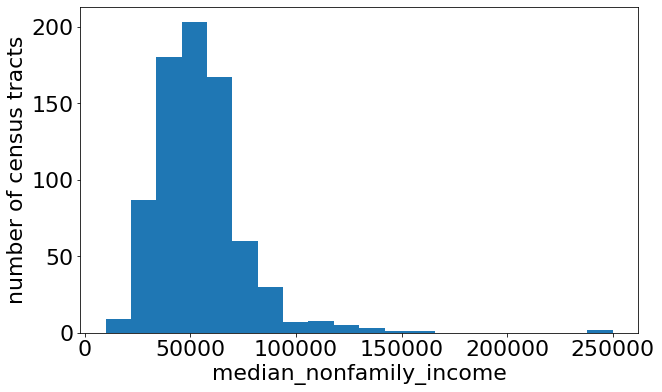

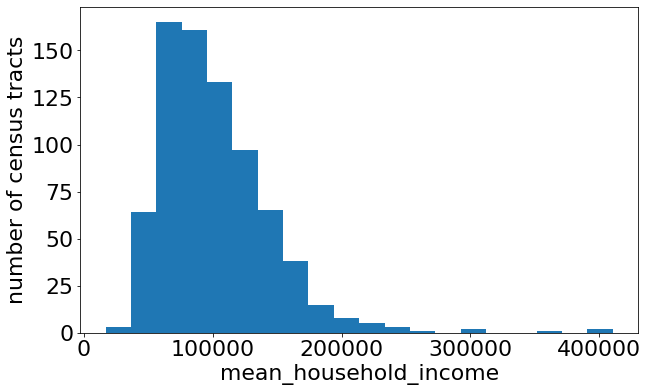

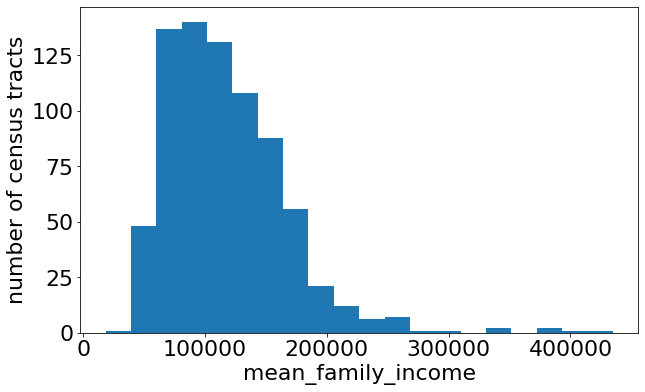

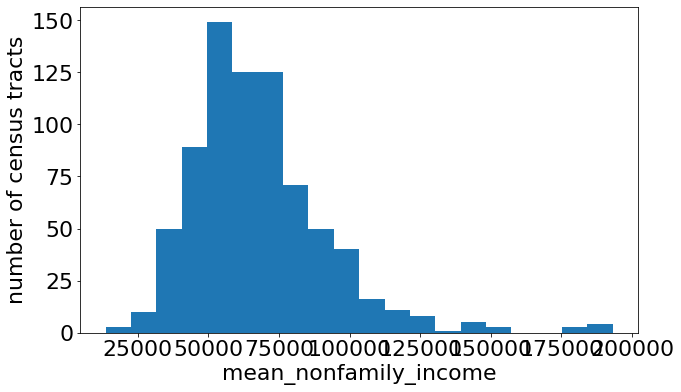

In [447]:
for column in income_df.columns:
    if column.split('_')[0] in {'median', 'mean'}:
        plt.figure(figsize=(10, 6))
        plt.hist(income_df[column], bins=20)
        plt.xlabel(column)
        plt.ylabel('number of census tracts')
        plt.show()

In [449]:
ct_stats_df = ct_stats_df.merge(income_df, on='ct_key', how='left')

### Poverty

In [488]:
# FOOD STAMPS/SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM (SNAP)
# https://data.census.gov/cedsci/table?t=SNAP%2FFood%20Stamps&g=0400000US08.140000&tid=ACSST5Y2018.S2201&hidePreview=false
food_stamps_df = pd.read_csv('census_tract/food_stamps.csv', header=1)
food_stamps_df = convert_to_ct_key(food_stamps_df)
food_stamps_df = food_stamps_df[food_stamps_df['ct_key'].isin(denver_census_tracts)]

In [511]:
column_to_new_column = {
    'Estimate!!Percent!!Households!!POVERTY STATUS IN THE PAST 12 MONTHS!!At or above poverty level': 'above_poverty_line',
    'Estimate!!Percent households not receiving food stamps/SNAP!!Households!!POVERTY STATUS IN THE PAST 12 MONTHS!!Below poverty level': 'below_poverty_line'}

In [512]:
poverty_df = food_stamps_df[['ct_key'] + list(column_to_new_column)]
poverty_df.rename(column_to_new_column, axis=1, inplace=True)

In [513]:
poverty_df.head()

,ct_key,above_poverty_line,below_poverty_line
0,8001007801,75.1,20.6
1,8001007802,70.3,20.2
2,8001007900,81.4,11.4
3,8001008000,84,10.1
4,8001008100,74.1,23.7


In [515]:
for column in ['above_poverty_line', 'below_poverty_line']:
    poverty_df[column] = poverty_df[column].astype(float)

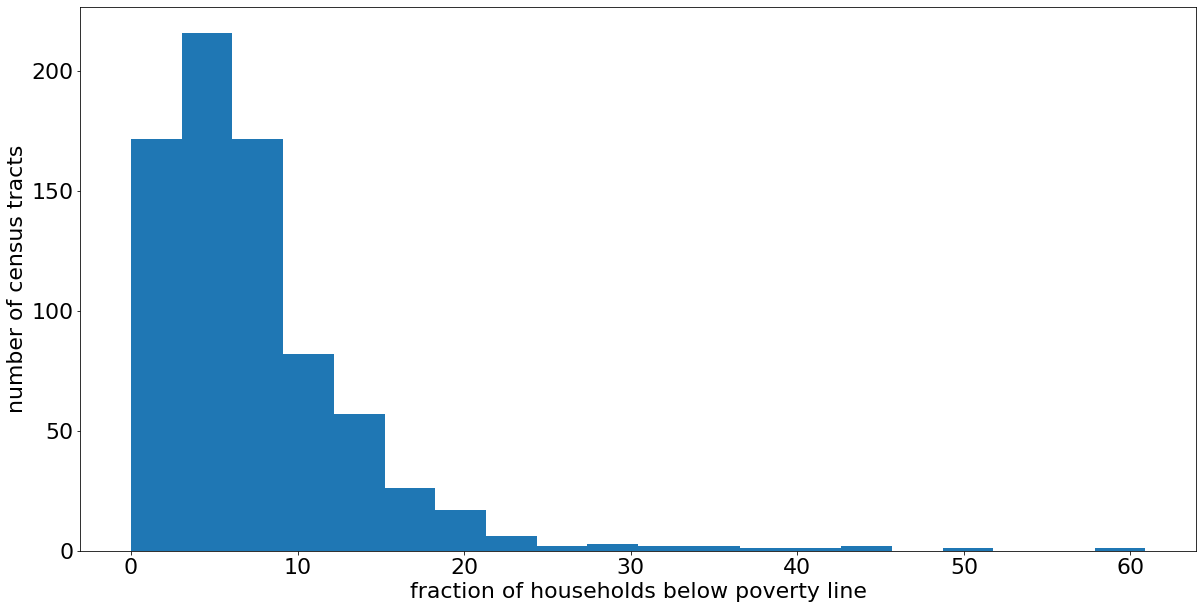

In [518]:
plt.figure(figsize=(20, 10))
plt.hist(poverty_df['below_poverty_line'], bins=20)
plt.xlabel('fraction of households below poverty line')
plt.ylabel('number of census tracts')
plt.show()

In [520]:
ct_stats_df = ct_stats_df.merge(poverty_df, on='ct_key', how='left')

### Economic data

In [561]:
# SELECTED ECONOMIC CHARACTERISTICS
# https://data.census.gov/cedsci/table?t=Income%20%28Households,%20Families,%20Individuals%29%3APoverty&g=0400000US08.140000&tid=ACSDP5Y2018.DP03&hidePreview=false
economic_df = pd.read_csv('census_tract/economic_characteristics.csv', header=1)
economic_df = convert_to_ct_key(economic_df)
economic_df = economic_df[economic_df['ct_key'].isin(denver_census_tracts)]

In [562]:
column_to_new_column = {
    'Percent Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Professional, scientific, and management, and administrative and waste management services': 'STEM_jobs',
    'Percent Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Educational services, and health care and social assistance': 'education&health_care'}

In [563]:
occupation_df = economic_df[['ct_key'] + list(column_to_new_column)]
occupation_df.rename(column_to_new_column, axis=1, inplace=True)

In [564]:
occupation_df.head()

,ct_key,STEM_jobs,education&health_care
0,8001007801,17.2,8.7
1,8001007802,16.6,6.1
2,8001007900,10.2,13.7
3,8001008000,17.8,14.2
4,8001008100,13.8,38.4


In [566]:
for column in ['STEM_jobs', 'education&health_care']:
    occupation_df[column] = occupation_df[column].astype(float)

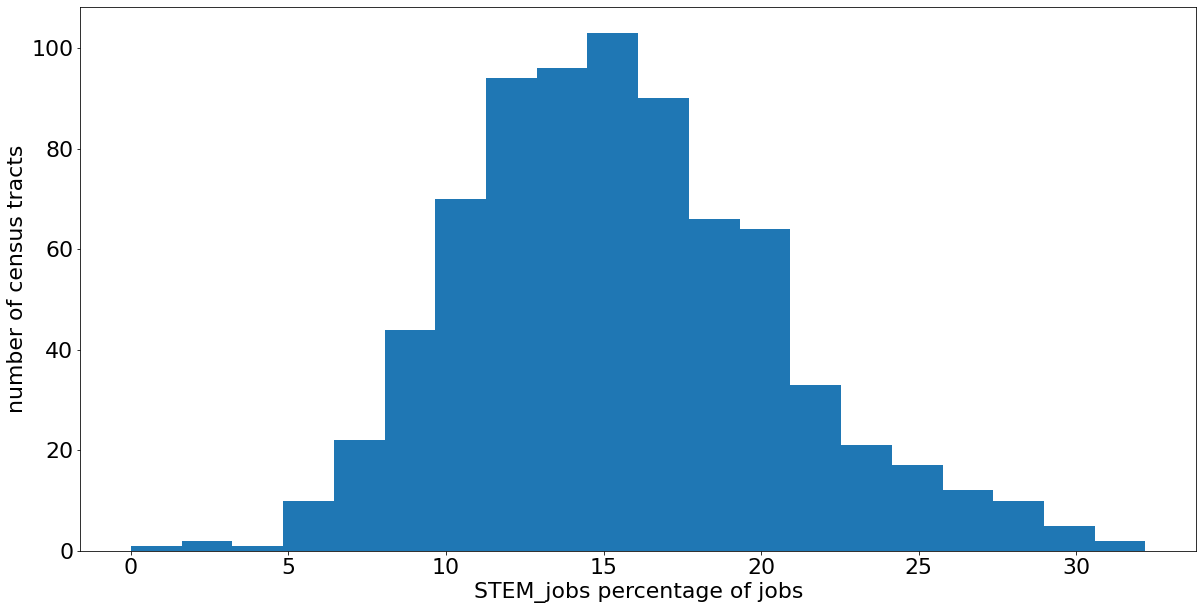

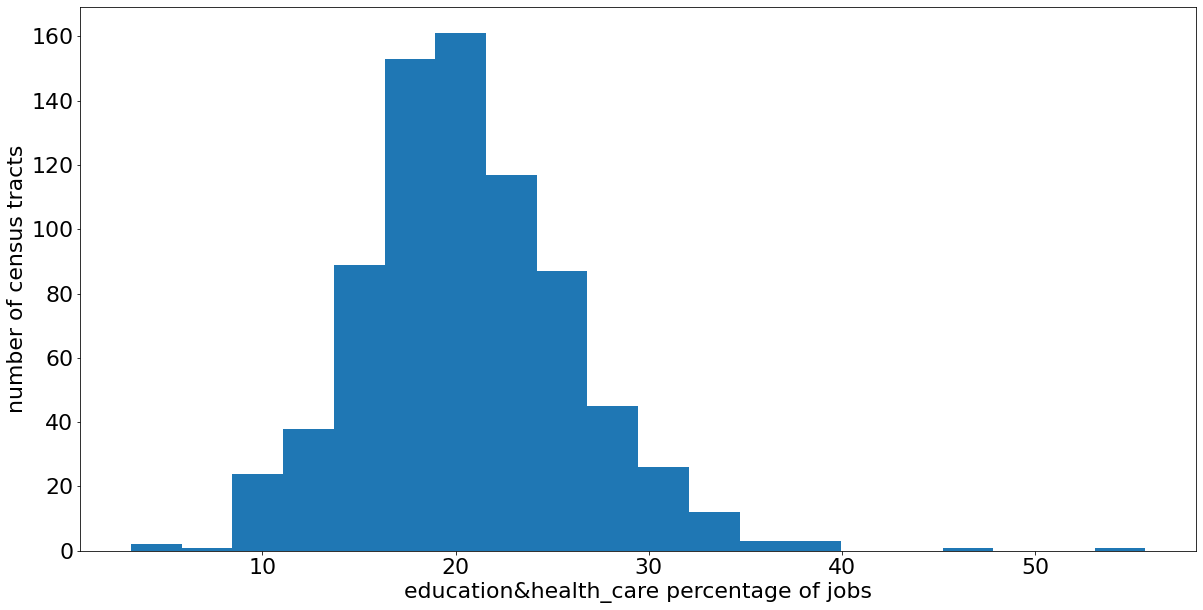

In [569]:
for column in ['STEM_jobs', 'education&health_care']:
    plt.figure(figsize=(20, 10))
    plt.hist(occupation_df[column], bins=20)
    plt.xlabel(column + ' percentage of jobs')
    plt.ylabel('number of census tracts')
    plt.show()

### Children

In [571]:
children_df = pd.read_csv('census_tract/children.csv', header=1)
children_df = convert_to_ct_key(children_df)
children_df = children_df[children_df['ct_key'].isin(denver_census_tracts)]

In [572]:
children_df.head(2)

,ct_key,Geographic Area Name,Estimate!!Total!!HOUSEHOLDS!!Total households,Margin of Error!!Total MOE!!HOUSEHOLDS!!Total households,Estimate!!Married-couple family household!!HOUSEHOLDS!!Total households,Margin of Error!!Married-couple family household MOE!!HOUSEHOLDS!!Total households,"Estimate!!Male householder, no wife present, family household!!HOUSEHOLDS!!Total households","Margin of Error!!Male householder, no wife present, family household MOE!!HOUSEHOLDS!!Total households","Estimate!!Female householder, no husband present, family household!!HOUSEHOLDS!!Total households","Margin of Error!!Female householder, no husband present, family household MOE!!HOUSEHOLDS!!Total households",Estimate!!Nonfamily household!!HOUSEHOLDS!!Total households,Margin of Error!!Nonfamily household MOE!!HOUSEHOLDS!!Total households,Estimate!!Total!!HOUSEHOLDS!!Average household size,Margin of Error!!Total MOE!!HOUSEHOLDS!!Average household size,Estimate!!Married-couple family household!!HOUSEHOLDS!!Average household size,Margin of Error!!Married-couple family household MOE!!HOUSEHOLDS!!Average household size,"Estimate!!Male householder, no wife present, family household!!HOUSEHOLDS!!Average household size","Margin of Error!!Male householder, no wife present, family household MOE!!HOUSEHOLDS!!Average household size","Estimate!!Female householder, no husband present, family household!!HOUSEHOLDS!!Average household size","Margin of Error!!Female householder, no husband present, family household MOE!!HOUSEHOLDS!!Average household size",Estimate!!Nonfamily household!!HOUSEHOLDS!!Average household size,Margin of Error!!Nonfamily household MOE!!HOUSEHOLDS!!Average household size,Estimate!!Total!!FAMILIES!!Total families,Margin of Error!!Total MOE!!FAMILIES!!Total families,Estimate!!Married-couple family household!!FAMILIES!!Total families,Margin of Error!!Married-couple family household MOE!!FAMILIES!!Total families,"Estimate!!Male householder, no wife present, family household!!FAMILIES!!Total families","Margin of Error!!Male householder, no wife present, family household MOE!!FAMILIES!!Total families","Estimate!!Female householder, no husband present, family household!!FAMILIES!!Total families","Margin of Error!!Female householder, no husband present, family household MOE!!FAMILIES!!Total families",Estimate!!Nonfamily household!!FAMILIES!!Total families,Margin of Error!!Nonfamily household MOE!!FAMILIES!!Total families,Estimate!!Total!!FAMILIES!!Average family size,Margin of Error!!Total MOE!!FAMILIES!!Average family size,Estimate!!Married-couple family household!!FAMILIES!!Average family size,Margin of Error!!Married-couple family household MOE!!FAMILIES!!Average family size,"Estimate!!Male householder, no wife present, family household!!FAMILIES!!Average family size","Margin of Error!!Male householder, no wife present, family household MOE!!FAMILIES!!Average family size","Estimate!!Female householder, no husband present, family household!!FAMILIES!!Average family size","Margin of Error!!Female householder, no husband present, family household MOE!!FAMILIES!!Average family size",Estimate!!Nonfamily household!!FAMILIES!!Average family size,Margin of Error!!Nonfamily household MOE!!FAMILIES!!Average family size,Estimate!!Total!!AGE OF OWN CHILDREN!!Households with own children of the householder under 18 years,Margin of Error!!Total MOE!!AGE OF OWN CHILDREN!!Households with own children of the householder under 18 years,Estimate!!Married-couple family household!!AGE OF OWN CHILDREN!!Households with own children of the householder under 18 years,Margin of Error!!Married-couple family household MOE!!AGE OF OWN CHILDREN!!Households with own children of the householder under 18 years,"Estimate!!Male householder, no wife present, family household!!AGE OF OWN CHILDREN!!Households with own children of the householder under 18 years","Margin of Error!!Male householder, no wife present, family household MOE!!AGE OF OWN CHILDREN!!Households with own children o

In [573]:
more_occupation = pd.read_csv('census_tract/more_occupation.csv', header=1)

In [574]:
more_occupation.head(2)

,id,Geographic Area Name,Estimate!!Total!!Civilian employed population 16 years and over,Margin of Error!!Total MOE!!Civilian employed population 16 years and over,Estimate!!Male!!Civilian employed population 16 years and over,Margin of Error!!Male MOE!!Civilian employed population 16 years and over,Estimate!!Percent Male!!Civilian employed population 16 years and over,Margin of Error!!Percent Male MOE!!Civilian employed population 16 years and over,Estimate!!Female!!Civilian employed population 16 years and over,Margin of Error!!Female MOE!!Civilian employed population 16 years and over,Estimate!!Percent Female!!Civilian employed population 16 years and over,Margin of Error!!Percent Female MOE!!Civilian employed population 16 years and over,"Estimate!!Total!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining","Margin of Error!!Total MOE!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining","Estimate!!Male!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining","Margin of Error!!Male MOE!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining","Estimate!!Percent Male!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining","Margin of Error!!Percent Male MOE!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining","Estimate!!Female!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining","Margin of Error!!Female MOE!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining","Estimate!!Percent Female!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining","Margin of Error!!Percent Female MOE!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining","Estimate!!Total!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Agriculture, forestry, fishing and hunting","Margin of Error!!Total MOE!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Agriculture, forestry, fishing and hunting","Estimate!!Male!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Agriculture, forestry, fishing and hunting","Margin of Error!!Male MOE!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Agriculture, forestry, fishing and hunting","Estimate!!Percent Male!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Agriculture, forestry, fishing and hunting","Margin of Error!!Percent Male MOE!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Agriculture, forestry, fishing and hunting","Estimate!!Female!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Agriculture, forestry, fishing and hunting","Margin of Error!!Female MOE!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Agriculture, forestry, fishing and hunting","Estimate!!Percent Female!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Agriculture, forestry, fishing and hunting","Margin of Error!!Percent Female MOE!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Agriculture, forestry, fishing and hunting","Estimate!!Total!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining!!Mining, quarrying, and oil and gas extraction","Margin of Error!!Total M

In [ ]:
denver_listing_dates_df = pd.read_csv('denver_listing_dates_cleaned.csv')
denver_listing_dates_df['zipcode'] = denver_listing_dates_df['zipcode'].astype(str)

In [ ]:
for event in 'list sale withdrawn expired cancelled'.split():
    column = event + '_date'
    denver_listing_dates_df[column] = pd.to_datetime(denver_listing_dates_df[column]).dt.date

In [ ]:
denver_listing_dates_df.head()

In [ ]:
# shapefile of all census tracts
census_tracts_shapes = gpd.read_file('census_tract/ct_18states shapefile/ct_18states.shp')
census_tracts_shapes['ct_key'] = census_tracts_shapes['CT_KEY'].astype(int)
census_tracts_shapes.drop(columns='CT_KEY', inplace=True)

# limit analysis to census tracts in Colorado
colorado_census_tracts_shapes = census_tracts_shapes[census_tracts_shapes['ct_key'].isin(colorado_census_tracts)]
colorado_census_tracts_shapes.shape

In [ ]:
# convert the latitude and longitude of each listing to a Point
geometry = [Point(xy) for xy in zip(denver_listing_dates_df.longitude, denver_listing_dates_df.latitude)]
gdf = gpd.GeoDataFrame(denver_listing_dates_df, crs='EPSG:4269', geometry=geometry)

# identify the census tract that each listing lies within
merged_file = gpd.sjoin(gdf, colorado_census_tracts_shapes, how='left', op='within')
denver_listing_dates_ct_df = pd.DataFrame(merged_file)

In [333]:
denver_listing_dates_ct_df.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,geometry,index_right,ct_key
0,139863800,80112,39.58203,-104.92111,2016-03-01,2016-03-01,NaT,NaT,NaT,Sale,475000.0,POINT (-104.92111 39.58203),10690.0,8.005007e+09
1,139817027,80112,39.56911,-104.80082,2016-03-01,2016-04-08,NaT,NaT,NaT,Sale,295000.0,POINT (-104.80082 39.56911),10769.0,8.005007e+09
2,482086548,80138,39.49819,-104.73505,2016-03-01,2016-05-19,NaT,NaT,NaT,Sale,412000.0,POINT (-104.73505 39.49819),10115.0,8.035014e+09
3,494122461,80211,39.75414,-105.03118,2016-03-01,NaT,NaT,2016-03-01,NaT,Expired,NaN,POINT (-105.03118 39.75414),10477.0,8.031001e+09
4,523793691,80516,40.09353,-104.99471,2016-03-01,2016-04-15,NaT,NaT,NaT,Sale,398000.0,POINT (-104.99471 40.09353),10342.0,8.123002e+09


In [337]:
denver_listing_dates_ct_df.isna().sum()

property_id            0
zipcode                0
latitude             825
longitude            825
list_date              0
sale_date         120054
withdrawn_date    402203
expired_date      415610
cancelled_date    436867
current_status         0
sale_price        120248
geometry               0
index_right          845
ct_key               845
dtype: int64

In [339]:
# ignore the 845 listings that aren't matched up with a census tracts
denver_listing_dates_ct_df = denver_listing_dates_ct_df[denver_listing_dates_ct_df['ct_key'].notna()]

In [340]:
denver_listing_dates_ct_df.isna().sum()

property_id            0
zipcode                0
latitude               0
longitude              0
list_date              0
sale_date         119885
withdrawn_date    401389
expired_date      414838
cancelled_date    436024
current_status         0
sale_price        120079
geometry               0
index_right            0
ct_key                 0
dtype: int64

In [341]:
census_tract_num_listings_df = denver_listing_dates_ct_df.groupby('ct_key').agg({'property_id': len})

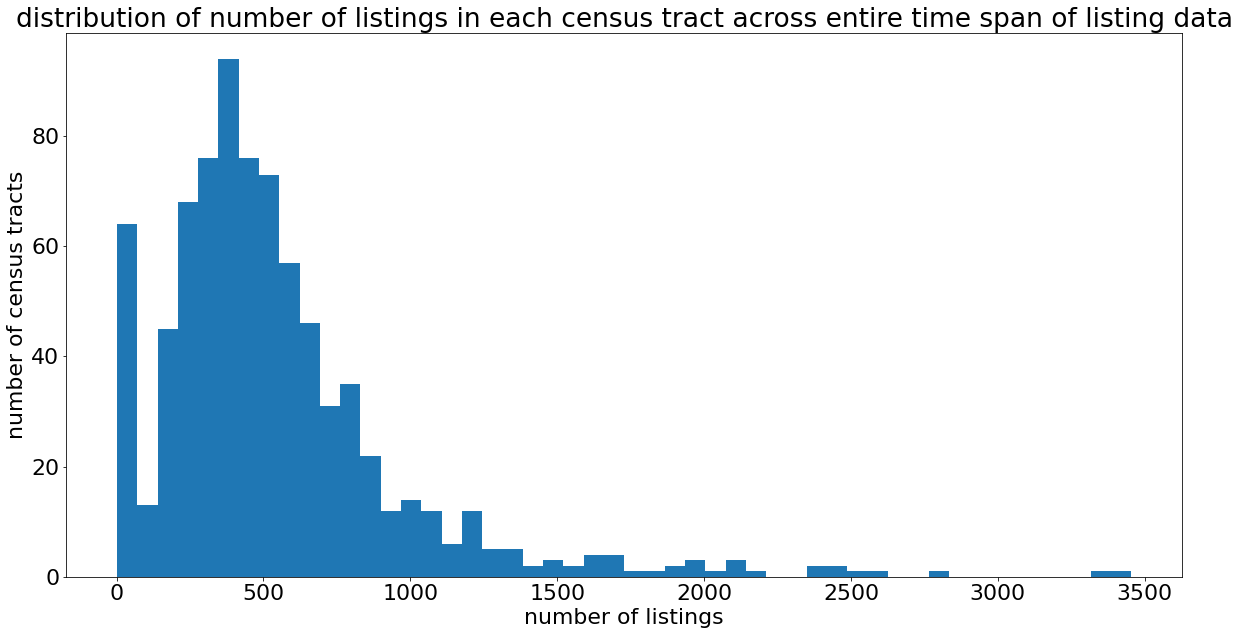

In [343]:
plt.figure(figsize=(20, 10))
plt.hist(census_tract_num_listings_df['property_id'], bins=50)
plt.xlabel('number of listings')
plt.ylabel('number of census tracts')
plt.title('distribution of number of listings in each census tract across entire time span of listing data')
plt.show()

In [336]:
# only consider price reductions that were greater than $1000
min_price_reduction = -1000
denver_price_change_df = pd.read_csv('denver_price_change.csv')
denver_price_change_df['zipcode'] = denver_price_change_df['zipcode'].astype(str)
denver_price_change_df = denver_price_change_df[denver_price_change_df.price_change <= min_price_reduction]

In [337]:
# don't double count listings that had multiple price reduction 
print(denver_price_change_df.shape)
denver_price_change_df.drop_duplicates(subset='property_id', keep='first', 
                                       inplace=True)
denver_price_change_df.drop(columns=['zipcode'], inplace=True, errors='ignore')
denver_price_change_df.rename(columns={'date': 'price_reduction_date'}, inplace=True)
print(denver_price_change_df.shape)

(254076, 4)
(94470, 3)


In [338]:
denver_price_change_df.head()

,property_id,price_change,price_reduction_date
0,13277930,-10000,2016-03-01
1,139452275,-3825000,2016-03-01
4,522713934,-300000,2016-03-03
6,140593415,-4900,2016-03-04
7,140256815,-10000,2016-03-04


In [183]:
denver_listing_dates_df_no_dups = denver_listing_dates_df_no_dups.merge(denver_price_change_df, how='left',
                                                                        on='property_id')

In [184]:
denver_listing_dates_df_no_dups.shape

(397020, 16)

In [185]:
denver_listing_dates_df_no_dups.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,geometry,index_right,CT_KEY,price_change,price_reduction_date
0,139863800,80112,39.58203,-104.92111,2016-03-01,2016-03-01,NaN,NaN,NaN,Sale,475000.0,POINT (-104.92111 39.58203),10690.0,8005006706,NaN,NaN
1,139817027,80112,39.56911,-104.80082,2016-03-01,2016-04-08,NaN,NaN,NaN,Sale,295000.0,POINT (-104.80082 39.56911),10769.0,8005006856,NaN,NaN
2,482086548,80138,39.49819,-104.73505,2016-03-01,2016-05-19,NaN,NaN,NaN,Sale,412000.0,POINT (-104.73505 39.49819),10115.0,8035013910,NaN,NaN
3,494122461,80211,39.75414,-105.03118,2016-03-01,NaN,NaN,2016-03-01,NaN,Expired,NaN,POINT (-105.03118 39.75414),10477.0,8031000502,-20000.0,2017-06-22
4,523793691,80516,40.09353,-104.99471,2016-03-01,2016-04-15,NaN,NaN,NaN,Sale,398000.0,POINT (-104.99471 40.09353),10342.0,8123002011,NaN,NaN


In [276]:
ct_stats_df.head()

,ct_key,rent.ct,grrent_yield.ct,rent_br3.ct,rent_br2.ct,rent_br1.ct,rent_br0.ct,cos.ct,lake.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,oth_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,vac_home.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,count_violent.ct,count_property.ct,count_total.ct,pt_violent.ct,pt_property.ct,pt_total.ct,education_score.ct,college_grads.ct,children_poverty.ct,leaid,member.sd,sch.sd,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd,sq_mi,population_from_land_area,population
0,8001007801,1316.0,6.024884,1625.0,1403.0,1143.0,810.0,100.0,100.0,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,0.0,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,0.0,0.0,0.0,0.0,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,100.0,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,53.0,186.0,239.0,14.201501,49.839228,64.040729,11.341791,0.074121,0.420058,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,0.419463,6319.830152,3956
1,8001007802,1239.0,9.187587,2003.0,1325.0,1316.0,1172.0,100.0,100.0,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,0.0,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,0.0,0.0,0.0,0.0,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,100.0,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,62.0,225.0,287.0,16.498137,59.872272,76.370410,8.345964,0.029777,0.460476,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,0.416736,6363.853734,4480
2,8001007900,1482.0,10.041348,1984.0,1504.0,1192.0,890.0,100.0,100.0,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,0.0,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,0.0,0.0,0.0,0.0,34.526095,65.473905,0.000000,5.882353,82.335231,46.875042,81.712204,100.0,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,66.0,262.0,328.0,11.881188,47.164716,59.045905,9.550928,0.151132,0.279825,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,1.088661,9410.795318,5853
3,8001008000,1499.0,7.532211,1906.0,1398.0,1086.0,NaN,100.0,100.0,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.0,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,0.0,0.0,0.0,0.0,51.528767,48.471233,0.000000,2.794521,66.152493,27.052337,79.212530,100.0,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,75.0,265.0,340.0,13.061651,46.151167,59.212818,10.130373,0.119054,0.280513,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,1.305677,9725.701163,6393
4,8001008100,2203.0,10.072085,2742.0,2628.0,2106.0,1990.0,100.0,100.0,100.0,820.952275,71.0,51.0,1.0,19.0,29.0,86.148238,12.758202,1.093560,0.000000,3.159174,0.000000,0.000000,90.400972,6.439854,0.0,13.122722,47.995140,30.012151,8.140948,0.729040,0.000000,0.0,0.0,0.0,0.0,3.009384,96.990616,0.850547,13.608748,99.648052,40.117025,28.282155,100.0,78.085732,16.726039,99.000522,35.907336,37.837838,11.711712,14.543115,0.000000,9.0,48.0,57.0,10.538642,56.206089,66.744731,12.581497,0.610526,0.169643,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,1.766163,1449.935365,1294


In [186]:
ct_level_price_red_df = denver_listing_dates_df_no_dups[denver_listing_dates_df_no_dups['price_change'].notna()]

In [187]:
ct_level_price_red_df.shape

(94425, 16)